### Setting up the Frameworks

In [1]:
import tensorflow, keras
print('TensorFlow version:',tensorflow.__version__)
print('Keras version:',keras.__version__)

from keras import backend as K

/anaconda/envs/py35/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


TensorFlow version: 1.12.0
Keras version: 2.2.4


Using TensorFlow backend.


### Preparing the Data
Before we can train the model, we need to prepare the data.

In [2]:
from keras.preprocessing.image import ImageDataGenerator

data_folder = 'resized_images'
# Our source images are 128x128, but the base model we're going to use was trained with 224x224 images
pretrained_size = (224,224)
batch_size = 16

print("Getting Data...")
datagen = ImageDataGenerator(rescale=1./255, # normalize pixel values
                             validation_split=0.3) # hold back 30% of the images for validation

print("Preparing training dataset...")
train_generator = datagen.flow_from_directory(
    data_folder,
    target_size=pretrained_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='training') # set as training data

print("Preparing validation dataset...")
validation_generator = datagen.flow_from_directory(
    data_folder,
    target_size=pretrained_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation') # set as validation data

classes = sorted(train_generator.class_indices.keys())
print("class names: ", classes)

Getting Data...
Preparing training dataset...
Found 1491 images belonging to 12 classes.
Preparing validation dataset...
Found 631 images belonging to 12 classes.
class names:  ['axes', 'boots', 'carabiners', 'crampons', 'gloves', 'hardshell_jackets', 'harnesses', 'helmets', 'insulated_jackets', 'pulleys', 'rope', 'tents']


### Downloading a trained model to use as a base

In [3]:
from keras import applications
#Load the base model, not including its final connected layer, and set the input shape to match our images
base_model = keras.applications.inception_resnet_v2.InceptionResNetV2(weights='imagenet', include_top=False, input_shape=train_generator.image_shape)

### Freeze the already trained layers and add a custom output layer for our classes

In [4]:
from keras import Model
from keras.layers import Flatten, Dense, Dropout
from keras import optimizers

# Freeze the already-trained layers in the base model
for layer in base_model.layers:
    layer.trainable = False

# Create layers for classification of our images
x = base_model.output
x = Flatten()(x)
prediction_layer = Dense(len(classes), activation='softmax')(x) 
model = Model(inputs=base_model.input, outputs=prediction_layer)

# Compile the model
#opt = optimizers.SGD(lr=0.01, momentum=0.3)
# We'll use the ADAM optimizer
opt = optimizers.Adam(lr=0.001)
model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

# Now print the full model, which will include the layers of the base model plus the dense layer we added
print(model.summary())

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 111, 111, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 111, 111, 32) 96          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 111, 111, 32) 0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
conv2d_2 (

### Training the Model


In [5]:
num_epochs = 5
history = model.fit_generator(
    train_generator,
    steps_per_epoch = train_generator.samples // batch_size,
    validation_data = validation_generator, 
    validation_steps = validation_generator.samples // batch_size,
    epochs = num_epochs)

Epoch 1/5
93/93 [==============================] - 42s 456ms/step - loss: 3.6279 - acc: 0.6767 - val_loss: 3.4904 - val_acc: 0.7276
Epoch 2/5
93/93 [==============================] - 33s 359ms/step - loss: 1.9505 - acc: 0.8163 - val_loss: 2.0186 - val_acc: 0.8260
Epoch 3/5
93/93 [==============================] - 33s 353ms/step - loss: 1.4719 - acc: 0.8851 - val_loss: 1.9245 - val_acc: 0.8472
Epoch 4/5
93/93 [==============================] - 33s 354ms/step - loss: 1.3022 - acc: 0.9037 - val_loss: 1.4380 - val_acc: 0.8911
Epoch 5/5
93/93 [==============================] - 33s 354ms/step - loss: 1.7024 - acc: 0.8692 - val_loss: 1.6446 - val_acc: 0.8764


### View the Loss History
We tracked average training and validation loss for each epoch. We can plot these to see where the levels of loss converged, and to detect *over-fitting*; which is indicated by a continued drop in training loss after validation loss has levelled out or started to increase.

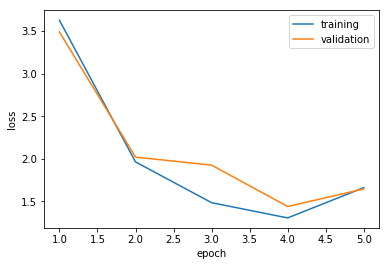

In [6]:
%matplotlib inline
from matplotlib import pyplot as plt

epoch_nums = range(1,num_epochs+1)
training_loss = history.history["loss"]
validation_loss = history.history["val_loss"]
plt.plot(epoch_nums, training_loss)
plt.plot(epoch_nums, validation_loss)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['training', 'validation'], loc='upper right')
plt.show()

### Using the Trained Model
Now that we've trained the model, we can use it to predict the class of an image.

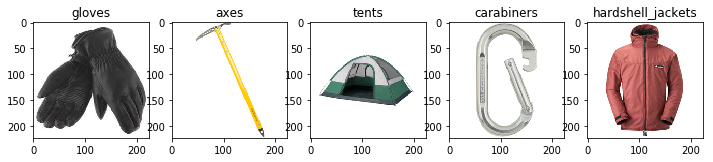

In [7]:
# Helper function to make image square
def reshape_image(img, size): 
    from PIL import Image, ImageOps 
    
    # Convert RGBA images to RGB
    if np.array(img).shape[2] == 4:
        img = img.convert('RGB')
        
    # resize the image
    img.thumbnail(size, Image.ANTIALIAS)
    newimg = Image.new("RGB", size, (255, 255, 255))
    newimg.paste(img, (int((size[0] - img.size[0]) / 2), int((size[1] - img.size[1]) / 2)))
  
    # return the resized image
    return np.array(newimg)

# Function to predict the class of an image
def predict_image(classifier, image_array):
    import numpy as np
    
    imgfeatures = image_array.astype('float32')
    imgfeatures /= 255
    
    # These are the classes our model can predict
    classnames = ['axes', 'boots', 'carabiners', 'crampons', 'gloves', 'hardshell_jackets', 'harnesses', 'helmets', 'insulated_jackets', 'pulleys', 'rope', 'tents']
    
    # Predict the class of each input image
    predictions = classifier.predict(imgfeatures)
    
    predicted_classes = []
    for prediction in predictions:
        class_idx = np.argmax(prediction)
        predicted_classes.append(classnames[int(class_idx)])
    return predicted_classes

# Predict class for new data
from PIL import Image
import requests
from io import BytesIO
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
%matplotlib inline

image_urls = []
image_urls.append('https://upload.wikimedia.org/wikipedia/commons/8/82/Skiglove.png')
image_urls.append('https://i.stack.imgur.com/HeliW.jpg')
image_urls.append('https://productimages.camping-gear-outlet.com/e5/62379.jpg')
image_urls.append('http://s7d1.scene7.com/is/image/MoosejawMB/MIKAJMKFMKCAPNABx1024698_zm?$product1000$')
image_urls.append('http://www.buffalosystems.co.uk/wp-content/uploads/2012/06/zoom_apline_jacket_dark_russet-2365x3286.jpg')

size = (224,224)

img_array = []

for url_idx in range(len(image_urls)):
    # Get the image
    response = requests.get(image_urls[url_idx])
    img = Image.open(BytesIO(response.content))
    img = reshape_image(img, size)
    img_array.append(img)
    
    
predicted_classes = predict_image(model, np.array(img_array))

fig = plt.figure(figsize=(12, 8))
idx = 0
for predicted_class in predicted_classes:
    a=fig.add_subplot(1,len(image_urls),idx+1)
    img = img_array[idx]
    imgplot = plt.imshow(img)
    a.set_title(predicted_class)
    idx += 1
